<font size=7> Social distancing: evidence of privilege in a pandemic from smartphones </font><br>
Nabarun Dasgupta, MPH, PhD | nab@unc.edu | @nabarund<br>
*Dr. Dasgupta is an epidemiologist at the University of North Carolina in Chapel Hill. He studies population level patterns of infectious disease, medication safety, and opioids.*<br>
Thanks to Ben White for data munging help. Code available on [GitHub](https://github.com/opioiddatalab/covid).

In [258]:
display "Notebook generated on $S_DATE at $S_TIME ET"

Notebook generated on 16 Apr 2020 at 00:40:49 ET


On March 23, 2020 Stuart Thompson and Yaryna Serkez of *The New York Times* [published](https://www.nytimes.com/interactive/2020/03/23/opinion/coronavirus-economy-recession.html) a fascinating use of cell phone GPS signal information to gauge movement and commuting, during the advent of social distancing. They compared the state-level data in a [slick graphic](https://www.nytimes.com/interactive/2020/03/23/opinion/coronavirus-economy-recession.html) to political leanings. But we wanted to understand more about other community level characteristics of slow versus fast adopters.<br>
<br>
We were provided access to the same location dataset on social distancing published today in the. We used a data merging approach we have [previously published](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6339867/). Repurposing code from an ongoing project, we merged in community-level data from the Robert Wood Johnson Foundation's [County Health Rankings](https://www.countyhealthrankings.org/). This very rich dataset contains dozens of explanatory variables about health, social, and economic indicators.<br>


In [259]:
// Load pre-procesed data
clear all
set scheme economist
use "https://github.com/opioiddatalab/covid/blob/master/analysiset.dta?raw=true"

// Basic distributions of 
tab rucc, m
tab iso5, m
table iso5, c(sum last3_sample)
su last3_sample
di "Total 3-day mobile traces: " r(sum)

// Set up reporting output programs 
program define pdiff
    version 16
    qui: lincom (levels5-levels1), ef
    local d=r(estimate)
    local se=r(se)
    di "Percent difference (high-low): " round(((`d'-1)*100),.1) "% (95% CI: " round((((`d'-1)*100)-(1.96*`se')),.1) "%, " round((((`d'-1)*100)+(1.96*`se')),.1) "%)"
end

// Create results frame
frame create results str20 strat level avg LL UL

// Set up program for main models
program define modelrun, rclass
    version 16
    syntax varlist(numeric)
    
    frame change default
    foreach var of local varlist {
    * Tabular
        qui: tabulate iso5, generate(levels)
        *table iso5, c(count pcp_rate mean pcp_rate sem pcp_rate) 
    * Base model
        glm `var' levels*, family(poisson) link(log) scale(x2) nocons eform 
    * Rurality-adjusted model for graphs
        glm `var' levels* i.rucc, family(poisson) link(log) scale(x2) eform nocons
        
        * Store results
        frame post results ("`var'") (1) (round((r(table)[1,1]),.1)) (round((r(table)[5,1]),.1)) (round((r(table)[6,1]),.1))
        frame post results ("`var'") (2) (round((r(table)[1,2]),.1)) (round((r(table)[5,2]),.1)) (round((r(table)[6,2]),.1))
        frame post results ("`var'") (3) (round((r(table)[1,3]),.1)) (round((r(table)[5,3]),.1)) (round((r(table)[6,3]),.1))
        frame post results ("`var'") (4) (round((r(table)[1,4]),.1)) (round((r(table)[5,4]),.1)) (round((r(table)[6,4]),.1))
        frame post results ("`var'") (5) (round((r(table)[1,5]),.1)) (round((r(table)[5,5]),.1)) (round((r(table)[6,5]),.1))

   * Percent difference between highest and lowest mobility tiers
        pdiff
        drop levels*
 
   * Plot graph
       frame change results
       la var level "Social Distancing: Lowest (1) to Highest (5)"
       line avg level if inlist(strat,"`var'")
       
    * Rate ratio of top 20% compared to bottom 80% of social distancing
        frame change default
         glm `var' toptier i.rucc, family(poisson) link(log) scale(x2) eform nocons

    frame change default
    }
end







  RUCC_2013 |      Freq.     Percent        Cum.
------------+-----------------------------------
          1 |        342       16.12       16.12
          2 |        306       14.43       30.55
          3 |        276       13.01       43.56
          4 |        165        7.78       51.34
          5 |         79        3.72       55.07
          6 |        446       21.03       76.10
          7 |        325       15.32       91.42
          8 |         88        4.15       95.57
          9 |         94        4.43      100.00
------------+-----------------------------------
      Total |      2,121      100.00


Distancing: |
 Lowest (1) |
 to Highest |
        (5) |      Freq.     Percent        Cum.
------------+-----------------------------------
          1 |        417       19.66       19.66
          2 |        423       19.94       39.60
          3 |        425       20.04       59.64
          4 |        429       20.23       79.87
          5 |        427       2

---
# Primary Care Providers

We wanted to see if places with more social distancing had better healthcare resources. So we looked at primary care providers per 100,000 population. 


note: pcp_rate has noninteger values

Iteration 0:   log likelihood = -23263.864  
Iteration 1:   log likelihood = -23165.014  
Iteration 2:   log likelihood = -23164.966  
Iteration 3:   log likelihood = -23164.966  

Generalized linear models                         Number of obs   =      2,077
Optimization     : ML                             Residual df     =      2,072
                                                  Scale parameter =          1
Deviance         =  34498.55721                   (1/df) Deviance =   16.64988
Pearson          =  37789.44307                   (1/df) Pearson  =   18.23815

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   22.31099
Log likelihood   = -23164.96602                   BIC             =   18671.21

------------------------------------------------------------------------------
             |                

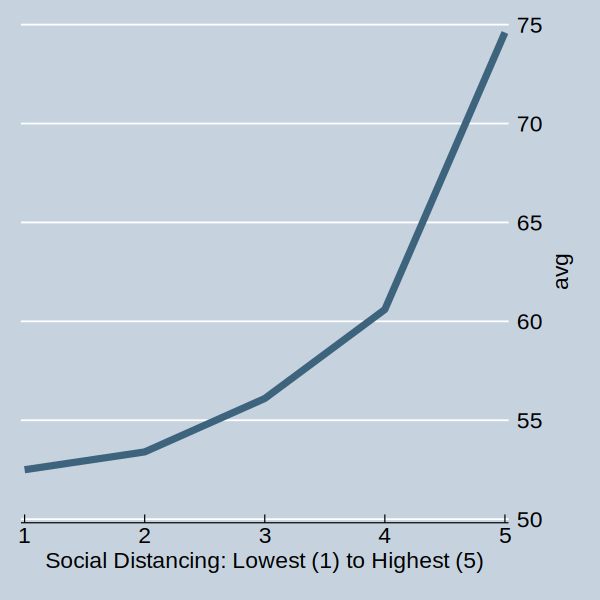

note: pcp_rate has noninteger values

Iteration 0:   log likelihood = -102847.84  
Iteration 1:   log likelihood = -85300.035  
Iteration 2:   log likelihood = -85094.082  
Iteration 3:   log likelihood = -85093.808  
Iteration 4:   log likelihood = -85093.808  

Generalized linear models                         Number of obs   =      2,077
Optimization     : ML                             Residual df     =      2,068
                                                  Scale parameter =          1
Deviance         =  158356.2413                   (1/df) Deviance =   76.57458
Pearson          =  1255857.601                   (1/df) Pearson  =   607.2812

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   81.94782
Log likelihood   = -85093.80805                   BIC             =   142559.5

----------------------------------------------------------------

In [260]:
// Comparing Primary Care Physicians per 100,000 population to social distancing
modelrun pcp_rate

Graph above: Comparing **Primary Care Physicians** per 100,000 population to social distancing


---

# Mental Health Providers

For people sequestered at home, mental health providers may play an emerging role. These data are from CMS National Provider Identification (NPI) via [RWJF](https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/2020-measures). It is expressed in rates per 100,000 population.

note: mhproviders_rate has noninteger values

Iteration 0:   log likelihood = -133283.26  
Iteration 1:   log likelihood = -131449.05  
Iteration 2:   log likelihood =  -131444.2  
Iteration 3:   log likelihood =  -131444.2  

Generalized linear models                         Number of obs   =      2,063
Optimization     : ML                             Residual df     =      2,058
                                                  Scale parameter =          1
Deviance         =  249598.9062                   (1/df) Deviance =   121.2823
Pearson          =   328561.585                   (1/df) Pearson  =   159.6509

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =    127.435
Log likelihood   = -131444.1989                   BIC             =   233892.4

-------------------------------------------------------------------------------
              |      

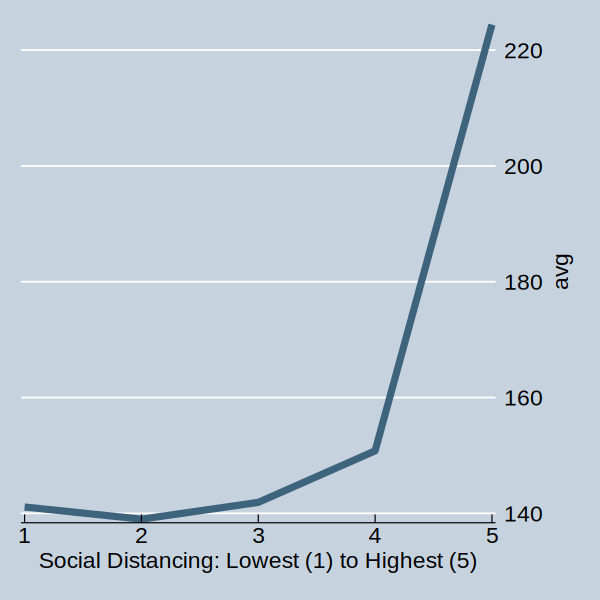

note: mhproviders_rate has noninteger values

Iteration 0:   log likelihood = -496526.29  
Iteration 1:   log likelihood = -352536.59  
Iteration 2:   log likelihood = -351168.84  
Iteration 3:   log likelihood =  -351164.6  
Iteration 4:   log likelihood =  -351164.6  

Generalized linear models                         Number of obs   =      2,063
Optimization     : ML                             Residual df     =      2,054
                                                  Scale parameter =          1
Deviance         =  689039.7084                   (1/df) Deviance =   335.4624
Pearson          =  10382636.95                   (1/df) Pearson  =   5054.838

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   340.4494
Log likelihood   = -351164.5999                   BIC             =   673363.8

--------------------------------------------------------

In [261]:
// Comparing mental health provider rate to social distancing
modelrun mhproviders_rate

Graph above: Comparing **mental health provider rate per 100k** to social distancing


---
# Health Insurance

Getting hospitalized for Covid-19 is sure to be expensive. After hearing that even some front line nurses in pulmonary infectious disease units in North Carolina do not have health insurance, we wanted to see if there was any association between health insurance status and social distancing. 

note: uninsured_p has noninteger values

Iteration 0:   log likelihood = -6324.1135  
Iteration 1:   log likelihood = -6317.3773  
Iteration 2:   log likelihood = -6317.3763  
Iteration 3:   log likelihood = -6317.3763  

Generalized linear models                         Number of obs   =      2,121
Optimization     : ML                             Residual df     =      2,116
                                                  Scale parameter =          1
Deviance         =  3817.099952                   (1/df) Deviance =   1.803922
Pearson          =  4013.346008                   (1/df) Pearson  =   1.896666

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   5.961694
Log likelihood   = -6317.376261                   BIC             =   -12390.7

------------------------------------------------------------------------------
             |             

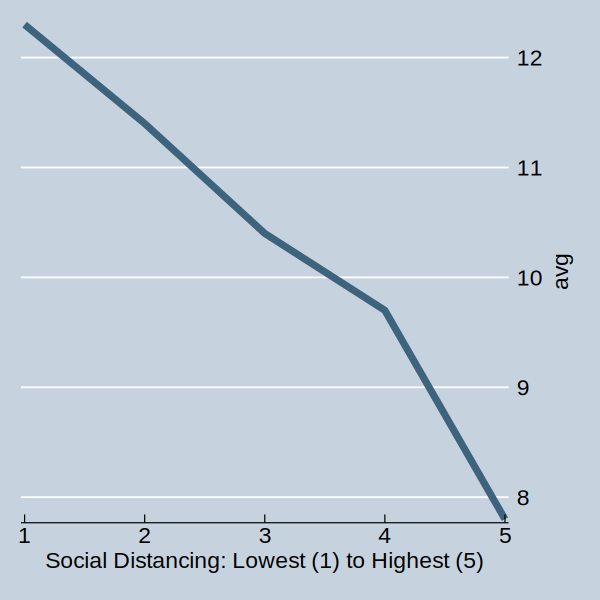

note: uninsured_p has noninteger values

Iteration 0:   log likelihood = -11227.076  
Iteration 1:   log likelihood = -10858.978  
Iteration 2:   log likelihood = -10856.609  
Iteration 3:   log likelihood = -10856.609  

Generalized linear models                         Number of obs   =      2,121
Optimization     : ML                             Residual df     =      2,112
                                                  Scale parameter =          1
Deviance         =  12895.56505                   (1/df) Deviance =   6.105855
Pearson          =  33914.90784                   (1/df) Pearson  =    16.0582

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   10.24574
Log likelihood   = -10856.60881                   BIC             =  -3281.601

------------------------------------------------------------------------------
             |             

In [262]:
// Comparing percent uninsured to social distancing
modelrun uninsured_p 

Graph above: Comparing **percent uninsured** to social distancing

Alarmingly, counties with lower social distancing also had more uninsured residents!

---
# Flu Vaccination

We had a hypothesis that counties that were more involved in preventative behaviors would be more likely to self-isolate more thoroughly. To test this, we examined whether earlier flu vaccination rates impacted how much the county was likely to slow down in the current coronavirus outbreak. This is quantified as the percent of annual Medicare enrollees having an annual flu vaccination, as reported by the Robert Wood Johnson Foundation. Since the flu vaccine is free to all Medicare beneficiaries, and this is the elderly age group with the most influenza mortality, this is a convenient metric to test *a priori* how conscientious the population was, on average.




        % Medicare Beneficiaries Getting Flu Vaccine
-------------------------------------------------------------
      Percentiles      Smallest
 1%           18              9
 5%           26              9
10%           30             12       Obs               2,118
25%           37             12       Sum of Wgt.       2,118

50%           43                      Mean           41.96789
                        Largest       Std. Dev.      8.653074
75%           48             62
90%           52             62       Variance       74.87568
95%           54             63       Skewness      -.6163759
99%           57             65       Kurtosis        3.25464

(bin=10, start=9, width=5.6)


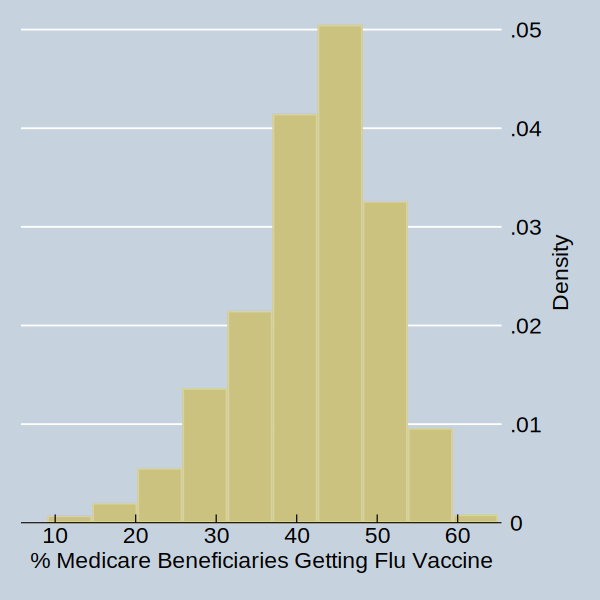

In [263]:
// Basic descriptive on background influenza vaccine
frame change default
summ fluvaccine, d
hist fluvaccine, bin(10)


Iteration 0:   log likelihood = -7848.3286  
Iteration 1:   log likelihood = -7847.0011  
Iteration 2:   log likelihood = -7847.0011  

Generalized linear models                         Number of obs   =      2,118
Optimization     : ML                             Residual df     =      2,113
                                                  Scale parameter =          1
Deviance         =  3931.567636                   (1/df) Deviance =   1.860657
Pearson          =  3657.538375                   (1/df) Pearson  =   1.730969

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   7.414543
Log likelihood   = -7847.001113                   BIC             =  -12250.27

------------------------------------------------------------------------------
             |                 OIM
  fluvaccine |        IRR   Std. Err.      z    P>|z|     [95% Conf. Interval

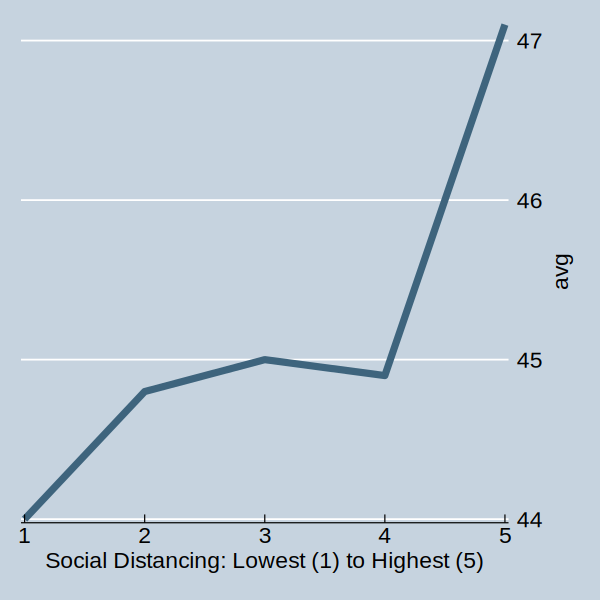


Iteration 0:   log likelihood = -57447.467  
Iteration 1:   log likelihood = -50119.264  
Iteration 2:   log likelihood = -50026.211  
Iteration 3:   log likelihood = -50026.145  
Iteration 4:   log likelihood = -50026.145  

Generalized linear models                         Number of obs   =      2,118
Optimization     : ML                             Residual df     =      2,109
                                                  Scale parameter =          1
Deviance         =  88289.85502                   (1/df) Deviance =   41.86337
Pearson          =  576054.2008                   (1/df) Pearson  =   273.1409

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   47.24754
Log likelihood   = -50026.14481                   BIC             =   72138.65

------------------------------------------------------------------------------
             |        

In [264]:
// Comparing background flu vaccination with current social distancing
modelrun fluvaccine

Grpah above: Comparing background **flu vaccination** with current social distancing

--- 
# Income

There is a trend emerging. So, since the places with more social distancing seem to have more health resources, perhaps there are trends in financial means? Income data are from the American Community Survey 5-year estimates via [RWJF](https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/2020-measures).


Iteration 0:   log likelihood = -4555743.8  
Iteration 1:   log likelihood = -4549599.9  
Iteration 2:   log likelihood = -4549599.7  

Generalized linear models                         Number of obs   =      2,121
Optimization     : ML                             Residual df     =      2,116
                                                  Scale parameter =          1
Deviance         =  9071008.348                   (1/df) Deviance =   4286.866
Pearson          =  9622647.205                   (1/df) Pearson  =   4547.565

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   4290.056
Log likelihood   = -4549599.731                   BIC             =    9054801

------------------------------------------------------------------------------
             |                 OIM
    income80 |        IRR   Std. Err.      z    P>|z|     [95% Conf. Interval

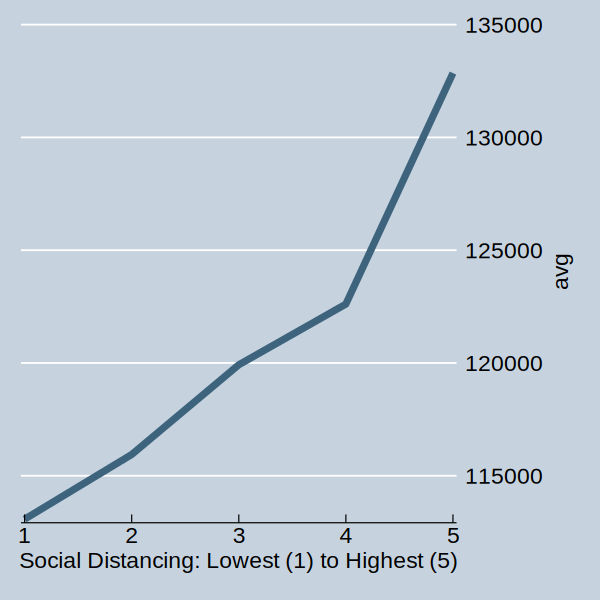


Iteration 0:   log likelihood = -1.635e+09  
Iteration 1:   log likelihood = -6.440e+08  
Iteration 2:   log likelihood = -4.557e+08  
Iteration 3:   log likelihood = -4.537e+08  
Iteration 4:   log likelihood = -4.536e+08  
Iteration 5:   log likelihood = -4.536e+08  

Generalized linear models                         Number of obs   =      2,121
Optimization     : ML                             Residual df     =      2,112
                                                  Scale parameter =          1
Deviance         =    907249540                   (1/df) Deviance =   429568.9
Pearson          =  4.24256e+12                   (1/df) Pearson  =   2.01e+09

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   427759.4
Log likelihood   = -453638865.6                   BIC             =   9.07e+08

--------------------------------------------------------

In [265]:
// Comparing 80th percentile income to social distancing
modelrun income80

Graph above: Comparing **80th percentile income** to social distancing

---
# Income Inequality

So places with more social distancing tend to be wealthier. What about income inequality? Is this merely a matter of have and have-nots? Or does the overall structure of society tell us something. There are many compelling ways to measure income inequality. We are using the ratio of the 80th percentile of income to the 20th percentile. Loosely interpreted, the closer to 4.0, the less inequality there is. Income data are from the American Community Survey 5-year estimates via [RWJF](https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/2020-measures).

note: incomeratio has noninteger values

Iteration 0:   log likelihood = -3695.8626  
Iteration 1:   log likelihood = -3695.8161  
Iteration 2:   log likelihood = -3695.8161  

Generalized linear models                         Number of obs   =      2,121
Optimization     : ML                             Residual df     =      2,116
                                                  Scale parameter =          1
Deviance         =   223.272399                   (1/df) Deviance =   .1055163
Pearson          =  232.9469514                   (1/df) Pearson  =   .1100884

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =    3.48969
Log likelihood   = -3695.816111                   BIC             =  -15984.53

------------------------------------------------------------------------------
             |                 OIM
 incomeratio |        IRR   Std. Err.

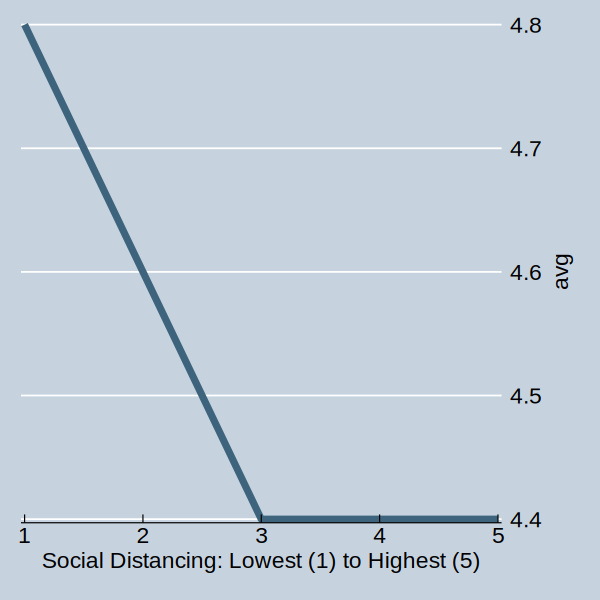

note: incomeratio has noninteger values

Iteration 0:   log likelihood = -4761.8603  
Iteration 1:   log likelihood = -4724.0954  
Iteration 2:   log likelihood = -4724.0423  
Iteration 3:   log likelihood = -4724.0423  

Generalized linear models                         Number of obs   =      2,121
Optimization     : ML                             Residual df     =      2,112
                                                  Scale parameter =          1
Deviance         =  2279.724777                   (1/df) Deviance =   1.079415
Pearson          =  3865.585551                   (1/df) Pearson  =   1.830296

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   4.463029
Log likelihood   =   -4724.0423                   BIC             =  -13897.44

------------------------------------------------------------------------------
             |             

In [266]:
// Comparing income inequality to social distancing
modelrun incomeratio

---

# Exploratory analyses




----------------------------------------------------------
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(drivea~p)  mean(drivea~p)   sem(drivea~p)
----------+-----------------------------------------------
        1 |            417       81.979514        .2926349
        2 |            423       81.803271        .2107526
        3 |            425       80.926193         .234848
        4 |            429        80.25963        .2805532
        5 |            427       77.530967        .4126577
----------------------------------------------------------


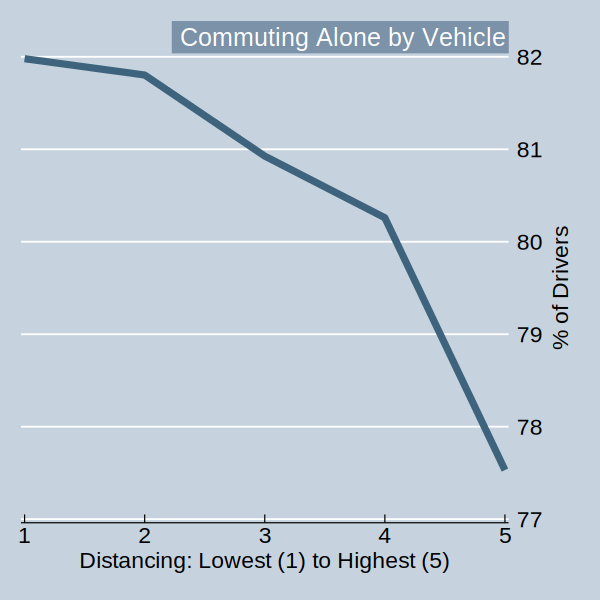

In [267]:
frame change default
foreach var of varlist drivealone_p {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "% of Drivers"
                        line `var' iso5, note("Commuting Alone by Vehicle")  
                            frame change default
                                frame drop `var'
}

---





----------------------------------------------
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(rucc)  mean(rucc)   sem(rucc)
----------+-----------------------------------
        1 |        417   5.3333335    .1066921
        2 |        423   4.8014183    .1150628
        3 |        425   4.4235296    .1151114
        4 |        429   3.8834498    .1172025
        5 |        427   3.5995317    .1221146
----------------------------------------------


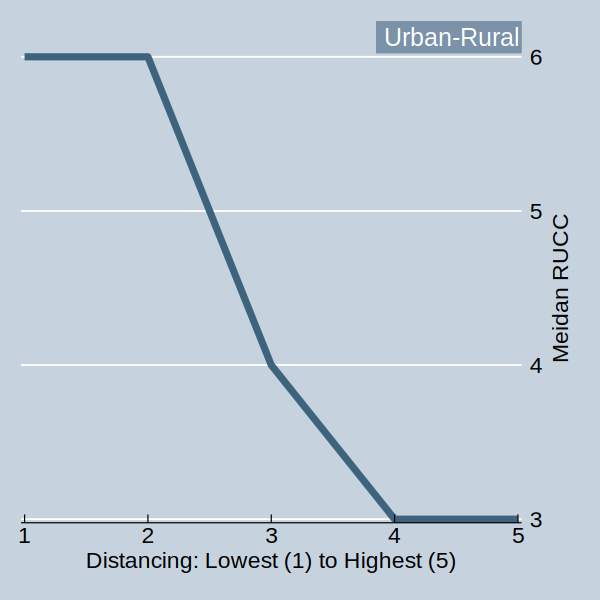

In [268]:
frame change default
foreach var of varlist rucc {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (median) `var', by(iso5)
                    la var `var' "Meidan RUCC"
                        line `var' iso5, note("Urban-Rural")   
                            frame change default
                                frame drop `var'
}




----------------------------------------------------------
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(longco~p)  mean(longco~p)   sem(longco~p)
----------+-----------------------------------------------
        1 |            417       27.447482        .6007633
        2 |            423       31.154374        .5872458
        3 |            425       32.213412        .5915631
        4 |            429       32.830536        .5764783
        5 |            427       32.974239        .5598415
----------------------------------------------------------


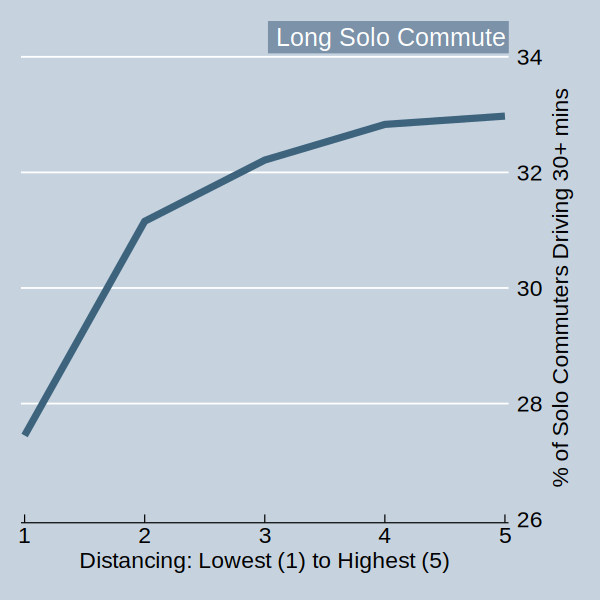

In [269]:
frame change default
foreach var of varlist longcommute_p {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "% of Solo Commuters Driving 30+ mins"
                        line `var' iso5, note("Long Solo Commute")     
                            frame change default
                                frame drop `var'
}

---
# Google location context

note: food has noninteger values

Iteration 0:   log likelihood = -4227.6995  
Iteration 1:   log likelihood = -4227.6486  
Iteration 2:   log likelihood = -4227.6486  

Generalized linear models                         Number of obs   =      2,107
Optimization     : ML                             Residual df     =      2,102
                                                  Scale parameter =          1
Deviance         =  297.1478511                   (1/df) Deviance =   .1413643
Pearson          =  273.0146038                   (1/df) Pearson  =   .1298833

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   4.017702
Log likelihood   = -4227.648568                   BIC             =   -15789.5

------------------------------------------------------------------------------
             |                 OIM
        food |        IRR   Std. Err.      z

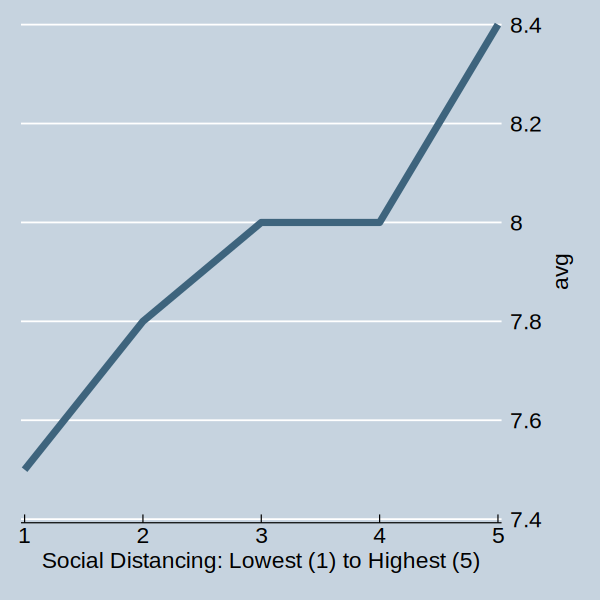

note: food has noninteger values

Iteration 0:   log likelihood = -7426.2561  
Iteration 1:   log likelihood = -7267.0247  
Iteration 2:   log likelihood = -7266.8283  
Iteration 3:   log likelihood = -7266.8283  

Generalized linear models                         Number of obs   =      2,107
Optimization     : ML                             Residual df     =      2,098
                                                  Scale parameter =          1
Deviance         =  6375.507234                   (1/df) Deviance =    3.03885
Pearson          =  14389.92703                   (1/df) Pearson  =   6.858878

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   6.906339
Log likelihood   =  -7266.82826                   BIC             =   -9680.53

------------------------------------------------------------------------------
             |                 OIM

In [270]:
modelrun food

note: physicalinactive has noninteger values

Iteration 0:   log likelihood = -6378.3497  
Iteration 1:   log likelihood =  -6377.503  
Iteration 2:   log likelihood =  -6377.503  

Generalized linear models                         Number of obs   =      2,121
Optimization     : ML                             Residual df     =      2,116
                                                  Scale parameter =          1
Deviance         =  2016.883249                   (1/df) Deviance =   .9531584
Pearson          =  1965.686685                   (1/df) Pearson  =   .9289635

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =    6.01839
Log likelihood   = -6377.503015                   BIC             =  -14190.92

-------------------------------------------------------------------------------
              |                 OIM
physicalina~e |        IRR   S

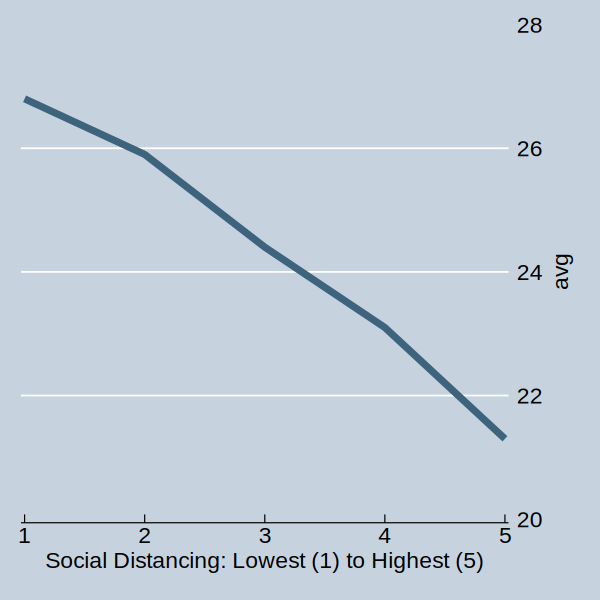

note: physicalinactive has noninteger values

Iteration 0:   log likelihood = -25776.059  
Iteration 1:   log likelihood = -23582.979  
Iteration 2:   log likelihood = -23548.207  
Iteration 3:   log likelihood = -23548.192  
Iteration 4:   log likelihood = -23548.192  

Generalized linear models                         Number of obs   =      2,121
Optimization     : ML                             Residual df     =      2,112
                                                  Scale parameter =          1
Deviance         =  36358.26216                   (1/df) Deviance =   17.21509
Pearson          =  165415.6983                   (1/df) Pearson  =   78.32183

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   22.21329
Log likelihood   = -23548.19247                   BIC             =    20181.1

--------------------------------------------------------

In [271]:
modelrun physicalinactive

note: exercise has noninteger values

Iteration 0:   log likelihood = -14237.354  
Iteration 1:   log likelihood = -14223.479  
Iteration 2:   log likelihood = -14223.478  

Generalized linear models                         Number of obs   =      2,121
Optimization     : ML                             Residual df     =      2,116
                                                  Scale parameter =          1
Deviance         =  15860.11331                   (1/df) Deviance =   7.495328
Pearson          =  13458.95004                   (1/df) Pearson  =   6.360562

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   13.41676
Log likelihood   = -14223.47807                   BIC             =  -347.6912

------------------------------------------------------------------------------
             |                 OIM
    exercise |        IRR   Std. Err.   

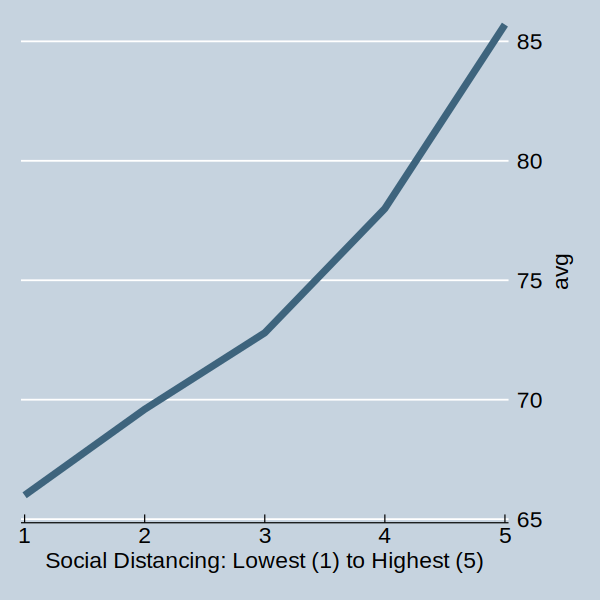

note: exercise has noninteger values

Iteration 0:   log likelihood = -120244.53  
Iteration 1:   log likelihood = -99225.518  
Iteration 2:   log likelihood = -98862.704  
Iteration 3:   log likelihood = -98862.079  
Iteration 4:   log likelihood = -98862.079  

Generalized linear models                         Number of obs   =      2,121
Optimization     : ML                             Residual df     =      2,112
                                                  Scale parameter =          1
Deviance         =  185137.3143                   (1/df) Deviance =   87.65971
Pearson          =  1649778.728                   (1/df) Pearson  =   781.1452

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   93.23063
Log likelihood   = -98862.07854                   BIC             =   168960.1

----------------------------------------------------------------

In [272]:
modelrun exercise


note: subunit_work has noninteger values

Iteration 0:   log likelihood = -7156.0945  
Iteration 1:   log likelihood = -7154.0243  
Iteration 2:   log likelihood = -7154.0243  

Generalized linear models                         Number of obs   =      1,964
Optimization     : ML                             Residual df     =      1,959
                                                  Scale parameter =          1
Deviance         =  3847.666082                   (1/df) Deviance =   1.964097
Pearson          =  3782.259295                   (1/df) Pearson  =   1.930709

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   7.290249
Log likelihood   =   -7154.0243                   BIC             =  -11006.92

------------------------------------------------------------------------------
             |                 OIM
subunit_work |        IRR   Std. Err

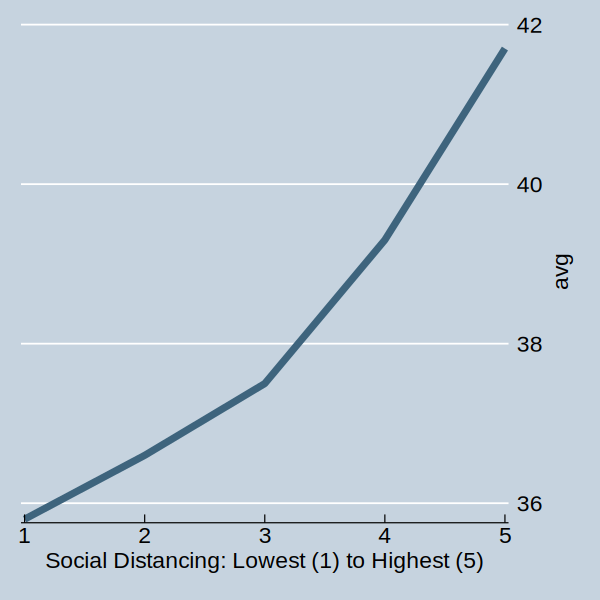

note: subunit_work has noninteger values

Iteration 0:   log likelihood = -42040.484  
Iteration 1:   log likelihood = -37424.878  
Iteration 2:   log likelihood = -37379.212  
Iteration 3:   log likelihood = -37379.187  
Iteration 4:   log likelihood = -37379.187  

Generalized linear models                         Number of obs   =      1,964
Optimization     : ML                             Residual df     =      1,955
                                                  Scale parameter =          1
Deviance         =  64297.99185                   (1/df) Deviance =     32.889
Pearson          =   370053.958                   (1/df) Pearson  =   189.2859

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   38.07351
Log likelihood   = -37379.18718                   BIC             =   49473.74

------------------------------------------------------------

In [273]:
modelrun subunit_work

In [274]:
modelrun subunit_retail

dependent variable subunit_retail has negative values


r(499);
